<a href="https://colab.research.google.com/github/DingLi23/s2search/blob/pipelining/pipelining/exp-cscl/exp-cscl_cscl_1w_ale_plotting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment Description



> This notebook is for experiment \<exp-cscl\> and data sample \<cscl\>.

### Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/exp-cscl/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


### Loading data

In [2]:

sys.path.insert(1, '../../')
import numpy as np, sys, os, pandas as pd
from getting_data import read_conf
from s2search_score_pdp import pdp_based_importance

sample_name = 'cscl'

f_list = [
    'title', 'abstract', 'venue', 'authors', 
    'year', 
    'n_citations'
    ]
ale_xy = {}
ale_metric = pd.DataFrame(columns=['feature_name', 'ale_range', 'ale_importance', 'absolute mean'])

for f in f_list:
    file = os.path.join('.', 'scores', f'{sample_name}_1w_ale_{f}.npz')
    if os.path.exists(file):
        nparr = np.load(file)
        quantile = nparr['quantile']
        ale_result = nparr['ale_result']
        values_for_rug = nparr.get('values_for_rug')
        
        ale_xy[f] = {
            'x': quantile,
            'y': ale_result,
            'rug': values_for_rug,
            'weird': ale_result[len(ale_result) - 1] > 20
        }
        
        if f != 'year' and f != 'n_citations':
            ale_xy[f]['x'] = list(range(len(quantile)))
            ale_xy[f]['numerical'] = False
        else:
            ale_xy[f]['xticks'] = quantile
            ale_xy[f]['numerical'] = True
            
        ale_metric.loc[len(ale_metric.index)] = [f, np.max(ale_result) - np.min(ale_result), pdp_based_importance(ale_result, f), np.mean(np.abs(ale_result))]               
           
        # print(len(ale_result))
        
print(ale_metric.sort_values(by=['ale_importance'], ascending=False))
print()


  feature_name  ale_range  ale_importance  absolute mean
1     abstract  17.316764        6.961733       6.225796
0        title   8.858415        2.086021       1.322043
2        venue  14.068588        1.989599       0.551489
4         year   2.144413        0.555637       0.456429
5  n_citations   1.331160        0.285659       0.220694
3      authors   0.031289        0.004425       0.001227



### ALE Plots

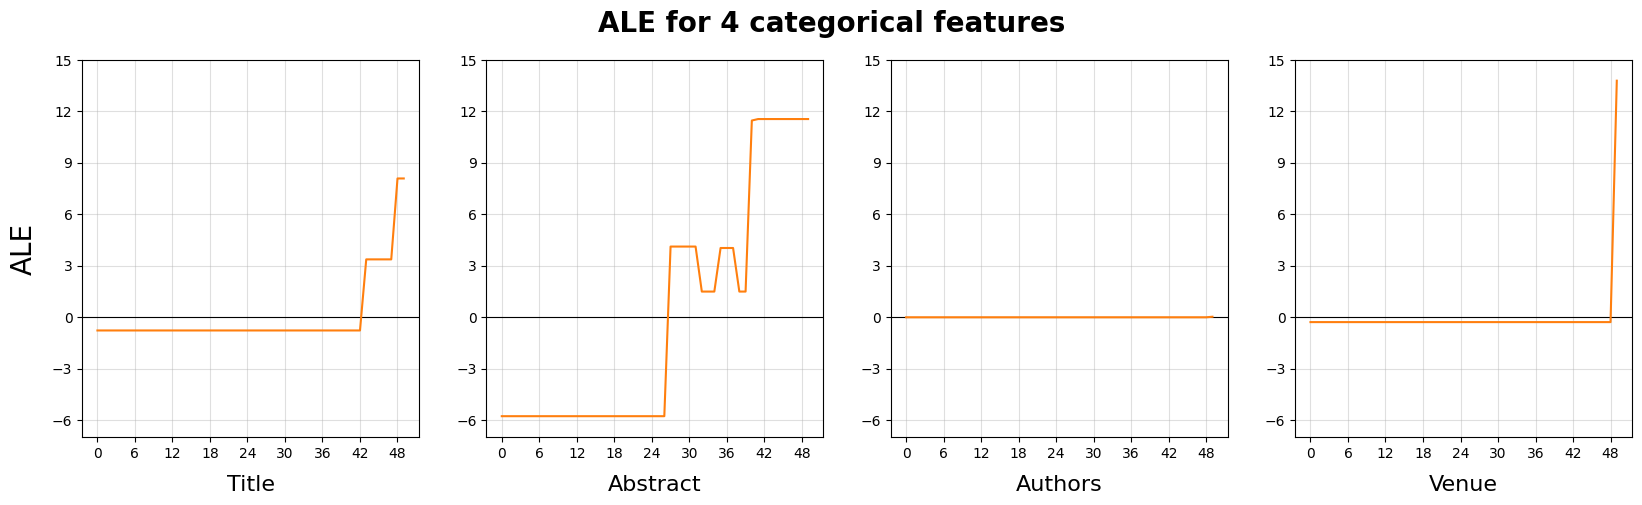

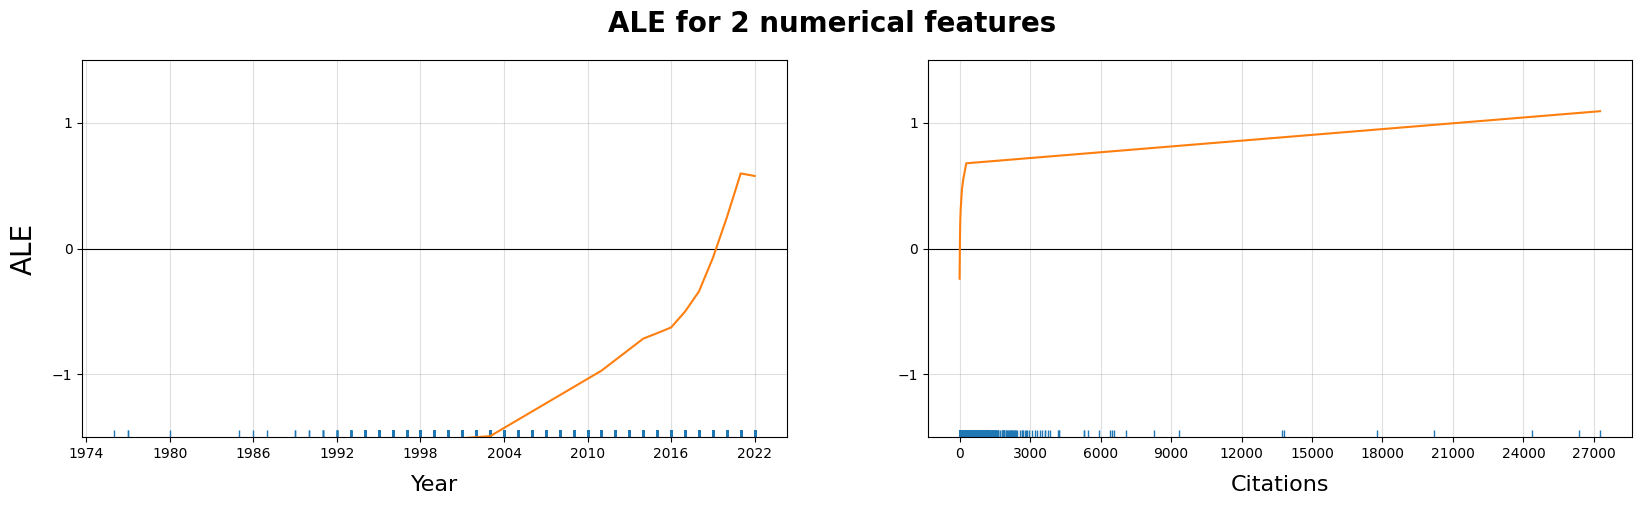

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

categorical_plot_conf = [
    {
        'xlabel': 'Title',
        'ylabel': 'ALE',
        'ale_xy': ale_xy['title']
    },
    {
        'xlabel': 'Abstract',
        'ale_xy': ale_xy['abstract']
    },    
    {
        'xlabel': 'Authors',
        'ale_xy': ale_xy['authors'],
        # 'zoom': {
        #     'inset_axes': [0.3, 0.3, 0.47, 0.47],
        #     'x_limit': [89, 93],
        #     'y_limit': [-1, 14],
        # }
    },    
    {
        'xlabel': 'Venue',
        'ale_xy': ale_xy['venue'],
        # 'zoom': {
        #     'inset_axes': [0.3, 0.3, 0.47, 0.47],
        #     'x_limit': [89, 93],
        #     'y_limit': [-1, 13],
        # }
    },
]

numerical_plot_conf = [
    {
        'xlabel': 'Year',
        'ylabel': 'ALE',
        'ale_xy': ale_xy['year'],
        # 'zoom': {
        #     'inset_axes': [0.15, 0.4, 0.4, 0.4],
        #     'x_limit': [2019, 2023],
        #     'y_limit': [1.9, 2.1],
        # },
    },
    {
        'xlabel': 'Citations',
        'ale_xy': ale_xy['n_citations'],
        # 'zoom': {
        #     'inset_axes': [0.4, 0.65, 0.47, 0.3],
        #     'x_limit': [-1000.0, 12000],
        #     'y_limit': [-0.1, 1.2],
        # },
    },
]

def pdp_plot(confs, title):
    fig, axes_list = plt.subplots(nrows=1, ncols=len(confs), figsize=(20, 5), dpi=100)
    subplot_idx = 0
    plt.suptitle(title, fontsize=20, fontweight='bold')
    # plt.autoscale(False)
    for conf in confs:
        axes = axes if len(confs) == 1 else axes_list[subplot_idx]
        
        sns.rugplot(conf['ale_xy']['rug'], ax=axes, height=0.02)

        axes.axhline(y=0, color='k', linestyle='-', lw=0.8)
        axes.plot(conf['ale_xy']['x'], conf['ale_xy']['y'])
        axes.grid(alpha = 0.4)

        # axes.set_ylim([-2, 20])
        axes.xaxis.set_major_locator(MaxNLocator(integer=True))
        axes.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        if ('ylabel' in conf):
            axes.set_ylabel(conf.get('ylabel'), fontsize=20, labelpad=10)
        
        # if ('xticks' not in conf['ale_xy'].keys()):
        #     xAxis.set_ticklabels([])

        axes.set_xlabel(conf['xlabel'], fontsize=16, labelpad=10)
        
        if not (conf['ale_xy']['weird']):
            if (conf['ale_xy']['numerical']):
                axes.set_ylim([-1.5, 1.5])
                pass
            else:
                axes.set_ylim([-7, 15])
                pass
                
        if 'zoom' in conf:
            axins = axes.inset_axes(conf['zoom']['inset_axes'])
            axins.xaxis.set_major_locator(MaxNLocator(integer=True))
            axins.yaxis.set_major_locator(MaxNLocator(integer=True))
            axins.plot(conf['ale_xy']['x'], conf['ale_xy']['y'])
            axins.set_xlim(conf['zoom']['x_limit'])
            axins.set_ylim(conf['zoom']['y_limit'])
            axins.grid(alpha=0.3)
            rectpatch, connects = axes.indicate_inset_zoom(axins)
            connects[0].set_visible(False)
            connects[1].set_visible(False)
            connects[2].set_visible(True)
            connects[3].set_visible(True)
            
        subplot_idx += 1

pdp_plot(categorical_plot_conf, f"ALE for {len(categorical_plot_conf)} categorical features")
# plt.savefig(os.path.join('.', 'plot', f'{sample_name}-1wale-categorical.png'), facecolor='white', transparent=False, bbox_inches='tight')

pdp_plot(numerical_plot_conf, f"ALE for {len(numerical_plot_conf)} numerical features")
# plt.savefig(os.path.join('.', 'plot', f'{sample_name}-1wale-numerical.png'), facecolor='white', transparent=False, bbox_inches='tight')
